In [1]:
from __future__ import absolute_import, division, print_function

import dolfin as dl
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from hippylib import *

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

np.random.seed(seed=1)

In [2]:
ndim = 2
nx = 32
ny = 32
mesh = dl.UnitSquareMesh(nx, ny)
Vh2 = dl.FunctionSpace(mesh, 'Lagrange', 2)
Vh1 = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vh = [Vh2, Vh1, Vh2]
print( "Number of dofs: STATE={0}, PARAMETER={1}, ADJOINT={2}".format(
    Vh[STATE].dim(), Vh[PARAMETER].dim(), Vh[ADJOINT].dim()) )

Number of dofs: STATE=4225, PARAMETER=1089, ADJOINT=4225


In [3]:
f = dl.Constant(0.0)
g = dl.Constant(1.0)
omega = dl.Constant(0.5)


def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + m*p*dl.ds
    
pde = PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)


Prior regularization: (delta_x - gamma*Laplacian)^order: delta=8, gamma=1, order=2


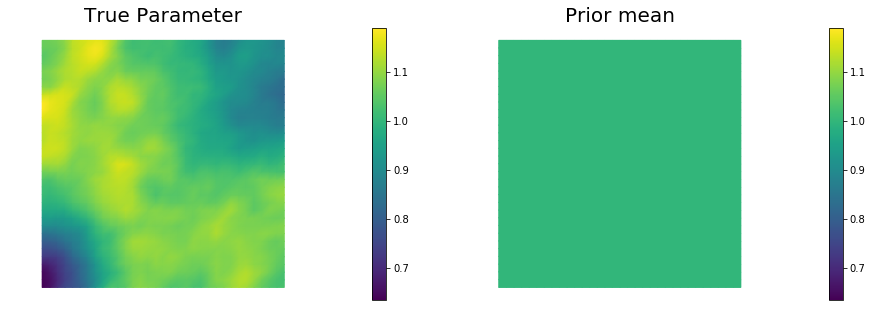

In [4]:
gamma = 1
delta = 8
prior = BiLaplacianPrior(Vh[PARAMETER], gamma, delta)

prior.mean = dl.interpolate(dl.Constant(1), Vh[PARAMETER]).vector()

def true_model(prior):
    noise = dl.Vector()
    prior.init_vector(noise,"noise")
    parRandom.normal(1., noise)
    mtrue = dl.Vector()
    prior.init_vector(mtrue, 0)
    prior.sample(noise,mtrue)
    return mtrue

print("Prior regularization: (delta_x - gamma*Laplacian)^order: delta={0}, gamma={1}, order={2}".format(delta, gamma,2))    


mtrue = true_model(prior)
                   
objs = [dl.Function(Vh[PARAMETER],mtrue), dl.Function(Vh[PARAMETER],prior.mean)]
mytitles = ["True Parameter", "Prior mean"]
nb.multi1_plot(objs, mytitles)
plt.show()

model = Model(pde,prior, misfit)

Number of observation points: 300


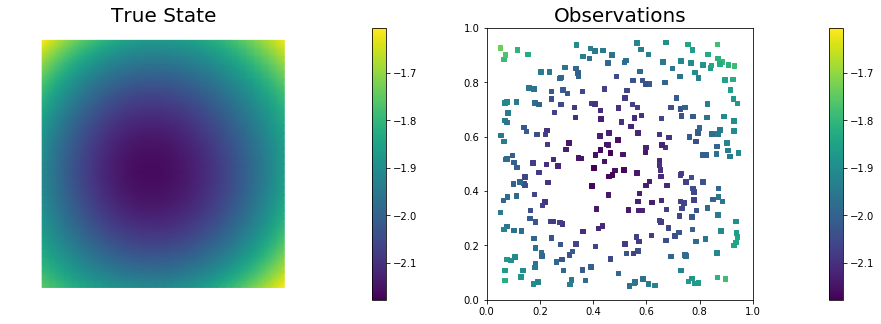

In [5]:
ntargets = 300
rel_noise = 0.005

targets = np.random.uniform(0.05,0.95, [ntargets, ndim] )
print( "Number of observation points: {0}".format(ntargets) )
misfit = PointwiseStateObservation(Vh[STATE], targets)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()

(yy, H xx) - (xx, H yy) =  1.9258690127081806e-13


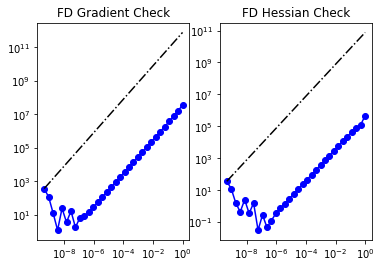

In [6]:
model = Model(pde, prior, misfit)

m0 = dl.interpolate(dl.Expression("sin(x[0])", degree=5), Vh[PARAMETER])
_ = modelVerify(model, m0.vector(), 1e-12)


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.015457e+03    1.015216e+03    2.406260e-01   -9.173708e+04   5.708506e+06   1.000000e+00   5.000000e-01
  2   2    5.243206e+02    5.234019e+02    9.186639e-01   -1.546201e+03   2.122104e+05   1.000000e+00   1.928067e-01
  3   1    2.180968e+02    2.172231e+02    8.736833e-01   -6.124938e+02   3.795535e+05   1.000000e+00   2.578548e-01
  4   8    1.976847e+02    1.933969e+02    4.287853e+00   -1.345360e+02   2.194244e+04   5.000000e-01   6.199850e-02
  5   1    1.595732e+02    1.553016e+02    4.271593e+00   -7.622993e+01   1.380263e+05   1.000000e+00   1.554961e-01
  6   7    1.547427e+02    1.497391e+02    5.003613e+00   -5.623458e+01   1.138526e+04   1.250000e-01   4.465913e-02
  7   1    1.529738e+02    1.479738e+02    4.999980e+00   -3.538130e+00   2.704885e+04   1.000000e+00   6.883561e-02
  8  10    1.523774e+02    1.472623e+02    5.115157e+00   -8.

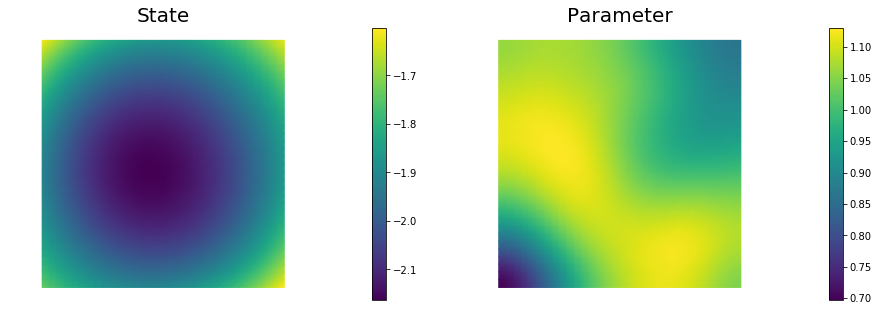

In [7]:
m = prior.mean.copy()
solver = ReducedSpaceNewtonCG(model)
solver.parameters["rel_tolerance"] = 1e-6
solver.parameters["abs_tolerance"] = 1e-12
solver.parameters["max_iter"]      = 50
solver.parameters["inner_rel_tolerance"] = 1e-15
solver.parameters["GN_iter"] = 5
solver.parameters["globalization"] = "LS"
solver.parameters["LS"]["c_armijo"] = 1e-4

    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

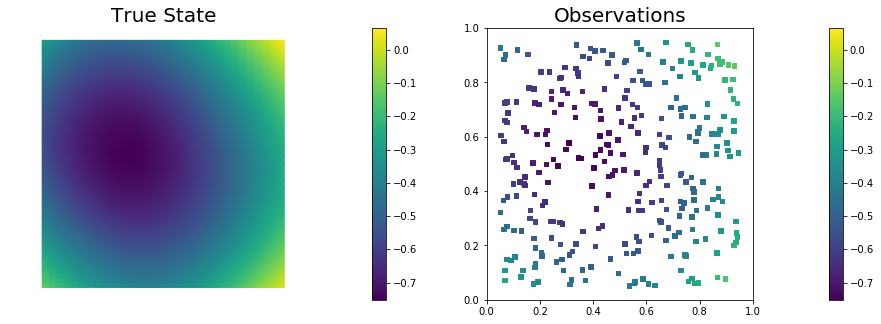

In [8]:
omega = dl.Constant(1.0)
    
def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = Model(pde,prior, misfit)

utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.096208e+04    3.040456e+04    5.575266e+02   -8.502620e+04   3.147682e+07   1.000000e+00   5.000000e-01
  2   1    1.977952e+04    1.922207e+04    5.574462e+02   -2.273486e+04   2.221446e+07   1.000000e+00   5.000000e-01
  3   2    1.625452e+04    1.569758e+04    5.569454e+02   -7.287098e+03   4.037581e+06   1.000000e+00   3.581502e-01
  4   4    1.242453e+04    1.186907e+04    5.554656e+02   -2.509196e+04   1.940756e+06   1.000000e+00   2.483076e-01
  5   1    4.155244e+03    3.599896e+03    5.553480e+02   -1.700602e+04   1.046647e+07   1.000000e+00   5.000000e-01
  6   2    3.425558e+03    2.870596e+03    5.549623e+02   -1.520685e+03   1.715748e+06   1.000000e+00   2.334701e-01
  7   7    2.851065e+03    2.297293e+03    5.537720e+02   -1.074146e+04   6.586505e+05   6.250000e-02   1.446545e-01
  8   5    2.085742e+03    1.534189e+03    5.515530e+02   -2.

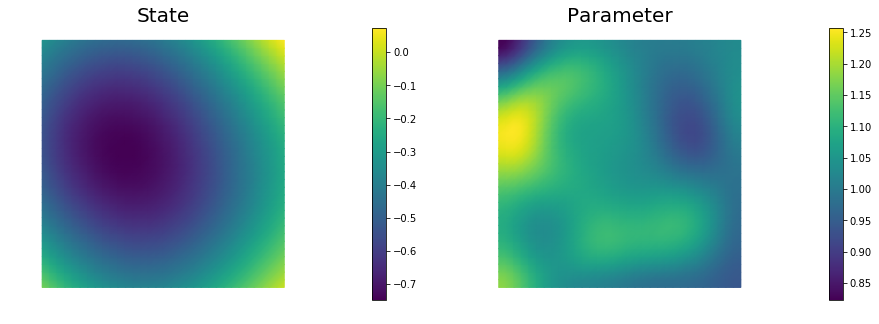

In [9]:
m = x[PARAMETER].copy()    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

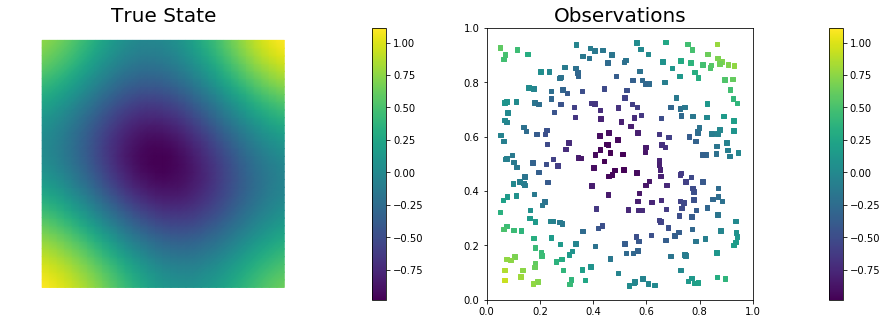

In [10]:
omega = dl.Constant(2)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    1.216477e+04    1.160750e+04    5.572760e+02   -7.323966e+03   2.570852e+06   1.000000e+00   5.000000e-01
  2   2    1.714270e+03    1.157914e+03    5.563556e+02   -2.083091e+04   2.051875e+06   1.000000e+00   5.000000e-01
  3   2    1.127632e+03    5.712875e+02    5.563442e+02   -1.170438e+03   5.836965e+05   1.000000e+00   4.764914e-01
  4   4    9.990110e+02    4.428750e+02    5.561360e+02   -2.588202e+02   4.724994e+05   1.000000e+00   4.287085e-01
  5   6    9.145628e+02    3.597293e+02    5.548335e+02   -1.686743e+02   4.466830e+05   1.000000e+00   4.168321e-01
  6   9    7.503885e+02    2.065870e+02    5.438015e+02   -3.376818e+02   4.392213e+05   1.000000e+00   4.133359e-01
  7   1    7.433168e+02    1.995159e+02    5.438008e+02   -1.407670e+01   4.409506e+05   1.000000e+00   4.141488e-01
  8   2    7.425928e+02    1.988033e+02    5.437895e+02   -1.

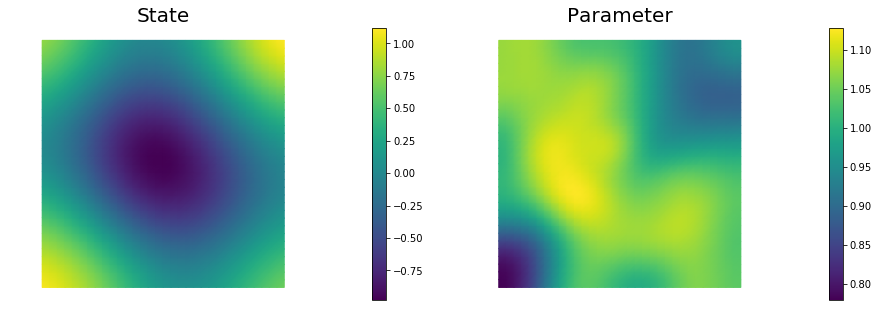

In [11]:
m = x[PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason])
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

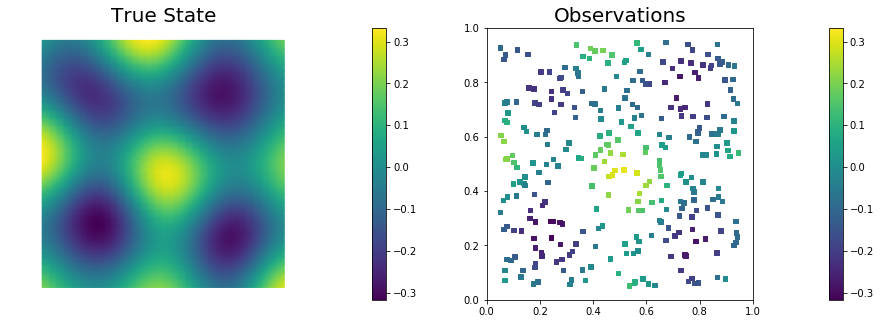

In [12]:
omega = dl.Constant(4)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.454005e+04    3.452433e+04    1.572080e+01   -1.177641e+04   5.149197e+07   1.000000e+00   5.000000e-01
  2   2    1.784903e+04    1.783353e+04    1.550954e+01   -3.465839e+04   1.479336e+07   1.000000e+00   5.000000e-01
  3   3    5.560704e+03    5.545410e+03    1.529399e+01   -2.318156e+04   4.773616e+06   1.000000e+00   3.044766e-01
  4   1    5.542197e+03    5.526903e+03    1.529387e+01   -3.741146e+01   4.275712e+06   1.000000e+00   2.881605e-01
  5   4    3.181608e+03    3.166769e+03    1.483889e+01   -5.002197e+03   2.854831e+06   1.000000e+00   2.354618e-01
  6   1    3.107067e+03    3.092228e+03    1.483908e+01   -1.588718e+02   1.002819e+07   1.000000e+00   4.413078e-01
  7   7    2.251515e+03    2.236789e+03    1.472624e+01   -3.634396e+03   1.293105e+06   1.000000e+00   1.584700e-01
  8   1    1.578166e+03    1.563439e+03    1.472695e+01   -1.

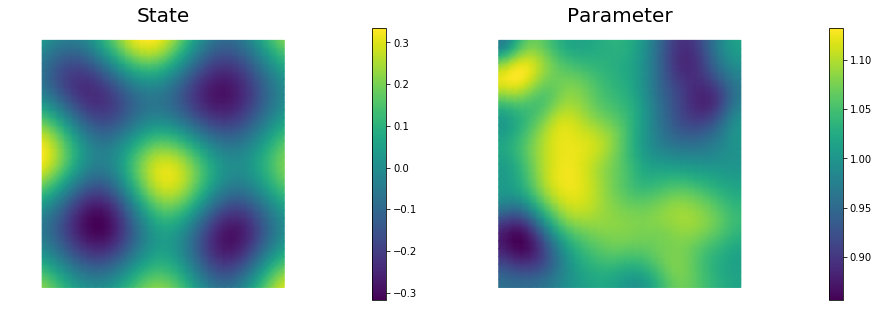

In [13]:
m = x[PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()

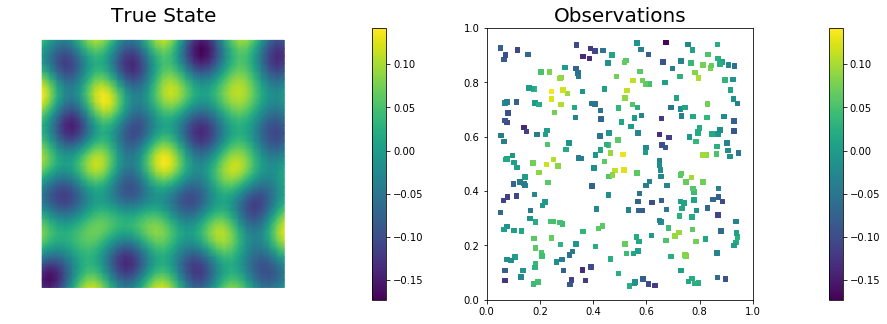

In [14]:
omega = dl.Constant(8)

def pde_varf(u,m,p):
    return -dl.inner(dl.nabla_grad(u), dl.nabla_grad(p))*dl.dx + omega*omega*dl.exp(2*m)*dl.inner(u, p)*dl.dx - f*p*dl.dx  + g*p*dl.ds
    
pde = PDEVariationalProblem(Vh, pde_varf, [], [], is_fwd_linear=True)

model = Model(pde,prior, misfit)


utrue = pde.generate_state()
x = [utrue, mtrue, None]
pde.solveFwd(x[STATE], x, 1e-9)
misfit.B.mult(x[STATE], misfit.d)
MAX = misfit.d.norm("linf")
noise_std_dev = rel_noise * MAX
parRandom.normal_perturb(noise_std_dev, misfit.d)
misfit.noise_variance = noise_std_dev*noise_std_dev

vmax = max( utrue.max(), misfit.d.max() )
vmin = min( utrue.min(), misfit.d.min() )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], utrue), mytitle="True State", subplot_loc=121, vmin=vmin, vmax=vmax)
nb.plot_pts(targets, misfit.d, mytitle="Observations", subplot_loc=122, vmin=vmin, vmax=vmax)
plt.show()


It  cg_it cost            misfit          reg             (g,dm)          ||g||L2        alpha          tolcg         
  1   1    3.832981e+04    3.829170e+04    3.811562e+01   -4.529516e+05   6.993372e+08   1.000000e+00   5.000000e-01
  2   1    1.640604e+04    1.636793e+04    3.811455e+01   -4.535021e+04   1.230220e+08   1.000000e+00   4.194191e-01
  3   1    1.567082e+04    1.563271e+04    3.811432e+01   -1.480065e+03   3.842636e+07   1.000000e+00   2.344074e-01
  4   3    5.559196e+03    5.520953e+03    3.824294e+01   -2.334738e+04   3.303344e+07   1.000000e+00   2.173370e-01
  5   1    5.328668e+03    5.290425e+03    3.824279e+01   -4.584574e+02   1.119809e+07   1.000000e+00   1.265403e-01
  6  10    3.422226e+03    3.383394e+03    3.883237e+01   -3.596649e+04   8.010929e+06   6.250000e-02   1.070282e-01
  7   1    3.372817e+03    3.333985e+03    3.883227e+01   -9.650296e+01   5.921213e+06   1.000000e+00   9.201572e-02
  8  11    2.377665e+03    2.337637e+03    4.002813e+01   -5.

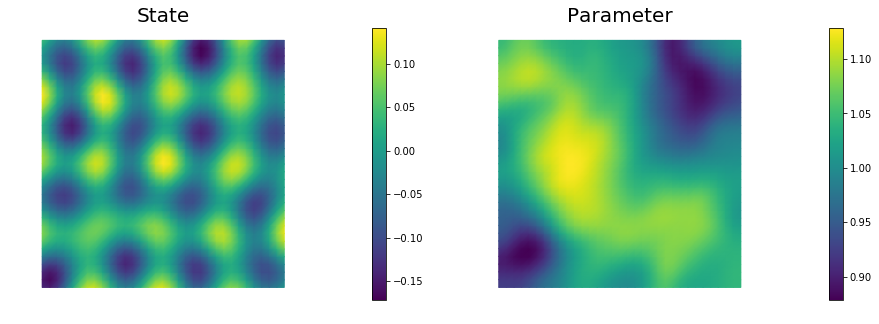

In [15]:
m = x[PARAMETER]    
x = solver.solve([None, m, None])
    
if solver.converged:
    print( "\nConverged in ", solver.it, " iterations.")
else:
    print( "\nNot Converged")

print( "Termination reason: ", solver.termination_reasons[solver.reason] )
print( "Final gradient norm: ", solver.final_grad_norm )
print( "Final cost: ", solver.final_cost )

plt.figure(figsize=(15,5))
nb.plot(dl.Function(Vh[STATE], x[STATE]), subplot_loc=121,mytitle="State")
nb.plot(dl.Function(Vh[PARAMETER], x[PARAMETER]), subplot_loc=122,mytitle="Parameter")
plt.show()